# Predicting IMDB_SCORE Using Regression Analysis

## Importing Required Libriaries

In [1]:
import os # for performing Opersting System related analysis like viewing the contents of a folder
import numpy as np # for mathematical calculations 
import pandas as pd # for Data analysis
import matplotlib.pyplot as plt # for Plotting the data
from sklearn.model_selection import train_test_split # to split the data into train and test sets
from sklearn.metrics import r2_score, explained_variance_score # scoring metrics for regression analysis
import lightgbm as lgb #Light Gradient Bossting Model
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor #Tree based models for Regression Analysis
from sklearn.experimental import enable_hist_gradient_boosting # Enabling the Histogram based gradient boosting
from sklearn.ensemble import HistGradientBoostingRegressor # Histogram based gradient boosting model
from sklearn.preprocessing import MinMaxScaler # to scale the data to a particular range like (0,1)

#comment the below line to use in any IDE other than Jupyter Notebook
#Magic command to plot the figures in jupyter notebook
%matplotlib inline 

## Reading the data from csv file

In [5]:
#Using the pandas built in function read_csv to read data from csv file. It loads the data directly into a pandas dataframe
movie_metadata = pd.read_csv('movie_metadata.csv')

In [6]:
# A Function to reduce the memory usage of a pandas dataframe
# Inspired from Kaggle Kernels
def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object and df[col].dtype != 'datetime64':  # Exclude strings and Datetimes           
            # Print current column type
            #print("******************************")
            #print("Column: ",col)
            #print("dtype before: ",df[col].dtype)            
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            #print("min for this col: ",mn)
            #print("max for this col: ",mx)
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            # Make float datatypes 32 bit
            else: 
                df[col] = df[col].astype(np.float32)
            
            # Print new column type
            #print("dtype after: ",df[col].dtype)
            #print("******************************")
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",(100*mem_usg)/start_mem_usg,"% of the initial size")
    return df, NAlist

movie_metadata, NAlist = reduce_mem_usage(movie_metadata)

Memory usage of properties dataframe is : 1.077423095703125  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  0.7167196273803711  MB
This is  66.52165061606004 % of the initial size


In [7]:
#Checking the data samples with "head" method which gives the top rows(default 5)
movie_metadata.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723,178,0,855,Joel David Moore,1000,760505847,Action|Adventure|Fantasy|Sci-Fi,...,3054,English,USA,PG-13,237000000,2009,936,7.9,1.78,33000
1,Color,Gore Verbinski,302,169,563,1000,Orlando Bloom,40000,309404152,Action|Adventure|Fantasy,...,1238,English,USA,PG-13,300000000,2007,5000,7.1,2.35,0
2,Color,Sam Mendes,602,148,0,161,Rory Kinnear,11000,200074175,Action|Adventure|Thriller,...,994,English,UK,PG-13,245000000,2015,393,6.8,2.35,85000
3,Color,Christopher Nolan,813,164,22000,23000,Christian Bale,27000,448130642,Action|Thriller,...,2701,English,USA,PG-13,250000000,2012,23000,8.5,2.35,164000
4,NaN,Doug Walker,0,6,131,65535,Rob Walker,131,161,Documentary,...,0,NaN,NaN,NaN,217,1915,12,7.1,0.18,0


In [8]:
#getting the pandas dataframe information using the "info" method
movie_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
color                        5024 non-null object
director_name                4939 non-null object
num_critic_for_reviews       5043 non-null uint16
duration                     5043 non-null uint16
director_facebook_likes      5043 non-null uint16
actor_3_facebook_likes       5043 non-null uint16
actor_2_name                 5030 non-null object
actor_1_facebook_likes       5043 non-null uint32
gross                        5043 non-null uint32
genres                       5043 non-null object
actor_1_name                 5036 non-null object
movie_title                  5043 non-null object
num_voted_users              5043 non-null uint32
cast_total_facebook_likes    5043 non-null uint32
actor_3_name                 5020 non-null object
facenumber_in_poster         5043 non-null uint8
plot_keywords                4890 non-null object
movie_imdb_link              5043 non-null o

## Feature Engineering 

### Dropping the columns which are not useful

In [9]:
movie_metadata.drop(['aspect_ratio', 'movie_imdb_link'], axis= 1, inplace = True)

### Checking Null values in data

In [10]:
movie_metadata.isnull().sum()

color                         19
director_name                104
num_critic_for_reviews         0
duration                       0
director_facebook_likes        0
actor_3_facebook_likes         0
actor_2_name                  13
actor_1_facebook_likes         0
gross                          0
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  23
facenumber_in_poster           0
plot_keywords                153
num_user_for_reviews           0
language                      12
country                        5
content_rating               303
budget                         0
title_year                     0
actor_2_facebook_likes         0
imdb_score                     0
movie_facebook_likes           0
dtype: int64

### Handling Nulls using the appropriate values

In [11]:
movie_metadata['color'].fillna('Color', inplace = True) #Filling with common value
movie_metadata['director_name'].fillna('Unk', inplace = True) # Filling with unknown value
movie_metadata['actor_2_name'].fillna('Unk', inplace = True) # Filling with unknown value
movie_metadata['actor_1_name'].fillna('Unk', inplace = True) # Filling with unknown value
movie_metadata['actor_3_name'].fillna('Unk', inplace = True) # Filling with unknown value
movie_metadata['plot_keywords'].fillna('Unk', inplace = True) # Filling with unknown value
movie_metadata['content_rating'].fillna('Un Rated', inplace = True) # Filling as Not rated
movie_metadata['language'].fillna('Unk', inplace = True) # Filling with unknown value
movie_metadata['country'].fillna('Unk', inplace = True) # Filling with unknown value

### Checking Nulls after Null Handling

In [12]:
movie_metadata.isnull().sum()

color                        0
director_name                0
num_critic_for_reviews       0
duration                     0
director_facebook_likes      0
actor_3_facebook_likes       0
actor_2_name                 0
actor_1_facebook_likes       0
gross                        0
genres                       0
actor_1_name                 0
movie_title                  0
num_voted_users              0
cast_total_facebook_likes    0
actor_3_name                 0
facenumber_in_poster         0
plot_keywords                0
num_user_for_reviews         0
language                     0
country                      0
content_rating               0
budget                       0
title_year                   0
actor_2_facebook_likes       0
imdb_score                   0
movie_facebook_likes         0
dtype: int64

### Analysing the plot_keywords feature to any useful information

In [13]:
#Common Keywords in plot_keywords feature
plot_keywords_list=[]
for row in movie_metadata.plot_keywords.apply(lambda x: x.split('|')):
    for item in row:
        plot_keywords_list.append(item.strip())
plot_keywords_list = np.unique(np.array(plot_keywords_list, dtype = 'object'))
for a,b in zip(*np.unique(plot_keywords_list, return_counts=True)):
        if b>1:
            print(a)

Dropping plot_keywords column as there is no useful information (Each plot_keyword is unique)

In [14]:
movie_metadata.drop('plot_keywords', axis =1, inplace = True)

### Separating Numericsl and Categorical Features

In [15]:
numeric_features = movie_metadata.columns[(movie_metadata.dtypes!='object') & (movie_metadata.columns!='title_year')]
categorical_features = list(movie_metadata.columns[movie_metadata.dtypes=='object'])
categorical_features.append('title_year')
numeric_features, categorical_features

(Index(['num_critic_for_reviews', 'duration', 'director_facebook_likes',
        'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross',
        'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster',
        'num_user_for_reviews', 'budget', 'actor_2_facebook_likes',
        'imdb_score', 'movie_facebook_likes'],
       dtype='object'),
 ['color',
  'director_name',
  'actor_2_name',
  'genres',
  'actor_1_name',
  'movie_title',
  'actor_3_name',
  'language',
  'country',
  'content_rating',
  'title_year'])

In [16]:
# Numerical features used for training
train_numeric_features = movie_metadata.columns[(movie_metadata.dtypes!='object') & (movie_metadata.columns!='imdb_score')]

### Cleaning the Language & Country features by reducing the categories

In [17]:
languages_list = []
for a,b in zip(*np.unique(movie_metadata['language'], return_counts = True)):
        if b>5 and a!='Unk':
            languages_list.append(a)
movie_metadata['cleaned_language'] = movie_metadata['language'].apply(lambda x:x if x in languages_list else 'other')
languages_list.append('other')

In [18]:
countries_list = []
for a,b in zip(*np.unique(movie_metadata['country'], return_counts = True)):
        if b>17 and a!='Unk':
            countries_list.append(a)
movie_metadata['cleaned_country'] = movie_metadata['country'].apply(lambda x:x if x in countries_list else 'other')
countries_list.append('other')

### Plotting the Histogram of numerical features

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020D7DB4C9C8>,
      dtype=object)

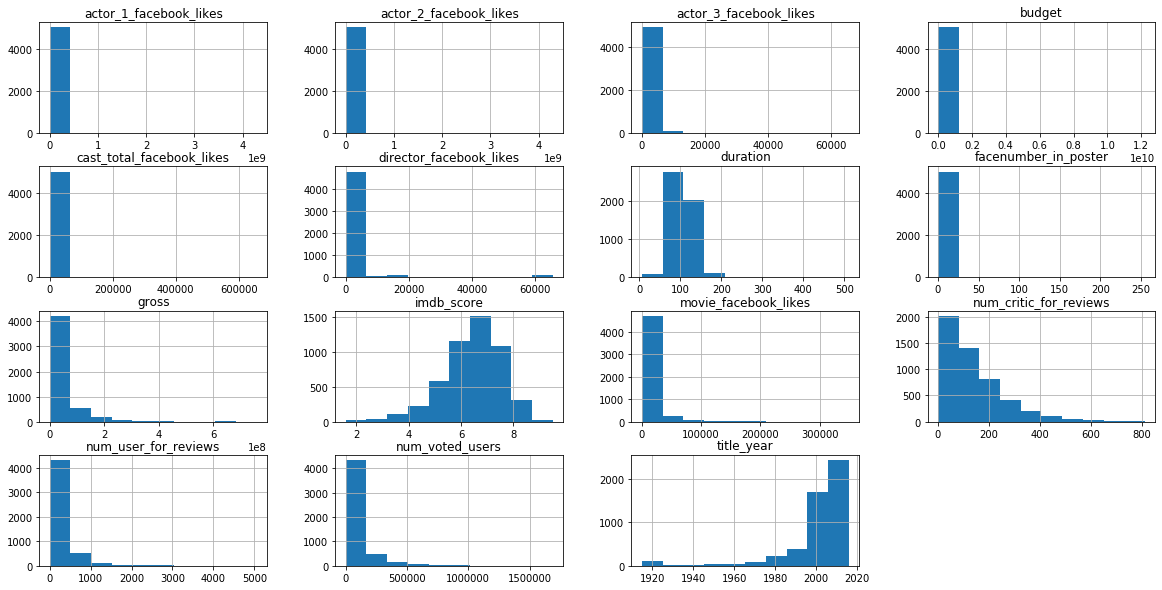

In [19]:
movie_metadata.hist(figsize = (20,10))

### Transforming the Genres feature 

In [20]:
#Transforming the genres feature to one hot encoded columns
def split_data(data, cols):
    data_series = list(data.apply(lambda x: np.array([y.strip() for y in x.split('|')])))
    for i in range(len(data_series)):
        row_length = len(data_series[i])
        if row_length<cols:
            for col in range(cols-row_length):
                data_series[i] = np.append(data_series[i], 'N/A')
    return data_series
def expand_data(data, cols, _list):
    data_series = pd.Series(split_data(data, cols))
    temp = []
    for item in _list:
        temp.append(data_series.apply(lambda x: 1 if item in x else 0))
    return temp            

In [21]:
genres = movie_metadata.genres.apply(lambda x: len(x.split('|'))).max()
print("Max Number of Genres for each movie : ", genres)

Max Number of Genres for each movie :  8


In [22]:
#Generating the list of unique Genres
genres_list=[]
for row in movie_metadata.genres.apply(lambda x: x.split('|')):
    for item in row:
        genres_list.append(item.strip())
genres_list = np.unique(np.array(genres_list, dtype = 'object'))
genres_list, genres_list.shape

(array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
        'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir',
        'Game-Show', 'History', 'Horror', 'Music', 'Musical', 'Mystery',
        'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport',
        'Thriller', 'War', 'Western'], dtype=object), (26,))

In [23]:
#Adding the Genres features to the data
movie_metadata[genres_list] = pd.DataFrame(np.array(expand_data(movie_metadata['genres'], genres, 
                                                               genres_list)).T, columns=genres_list)
movie_metadata[genres_list]

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5039,0,0,0,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
5040,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
5041,0,0,0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


In [24]:
movie_metadata_stats = movie_metadata.describe().T
#Generating the IQR value to check the the outliers
movie_metadata_stats['IQR'] = movie_metadata_stats['75%'] - movie_metadata_stats['25%']

movie_metadata_stats['lower_iqr_boundary'] = movie_metadata_stats['25%']-1.5*movie_metadata_stats['IQR']
movie_metadata_stats['higher_iqr_boundary'] = movie_metadata_stats['75%']+1.5*movie_metadata_stats['IQR']
movie_metadata_stats

,count,mean,std,min,25%,50%,75%,max,IQR,lower_iqr_boundary,higher_iqr_boundary
num_critic_for_reviews,5043.0,1.388043e+02,1.217921e+02,0.0,48.0,109.0,194.0,8.130000e+02,146.0,-1.710000e+02,4.130000e+02
duration,5043.0,1.069001e+02,2.575656e+01,6.0,93.0,103.0,118.0,5.110000e+02,25.0,5.550000e+01,1.555000e+02
director_facebook_likes,5043.0,2.023857e+03,9.628337e+03,0.0,7.0,52.0,218.0,6.553500e+04,211.0,-3.095000e+02,5.345000e+02
actor_3_facebook_likes,5043.0,9.409586e+02,4.677610e+03,0.0,134.5,374.0,638.0,6.553500e+04,503.5,-6.207500e+02,1.393250e+03
actor_1_facebook_likes,5043.0,5.968235e+06,1.599209e+08,0.0,615.5,989.0,11000.0,4.294967e+09,10384.5,-1.496125e+04,2.657675e+04
gross,5043.0,3.997229e+07,6.483777e+07,161.0,303781.5,15279680.0,51357065.5,7.605058e+08,51053284.0,-7.627614e+07,1.279370e+08
num_voted_users,5043.0,8.366816e+04,1.384853e+05,5.0,8593.5,34359.0,96309.0,1.689764e+06,87715.5,-1.229798e+05,2.278822e+05
cast_total_facebook_likes,5043.0,9.699064e+03,1.816380e+04,0.0,1411.0,3090.0,13756.5,6.567300e+05,12345.5,-1.710725e+04,3.227475e+04
facenumber_in_poster,5043.0,2.024985e+00,1.301826e+01,0.0,0.0,1.0,2.0,2.550000e+02,2.0,-3.000000e+00,5.000000e+00
num_user_for_reviews,5043.0,2.716349e+02,3.776038e+02,0.0,64.0,155.0,324.0,5.060000e+03,260.0,-3.260000e+02,7.140000e+02


In [25]:
#Checking the Correlation of features
feature_correlation = movie_metadata.corr()
feature_correlation.style.background_gradient(cmap='coolwarm')

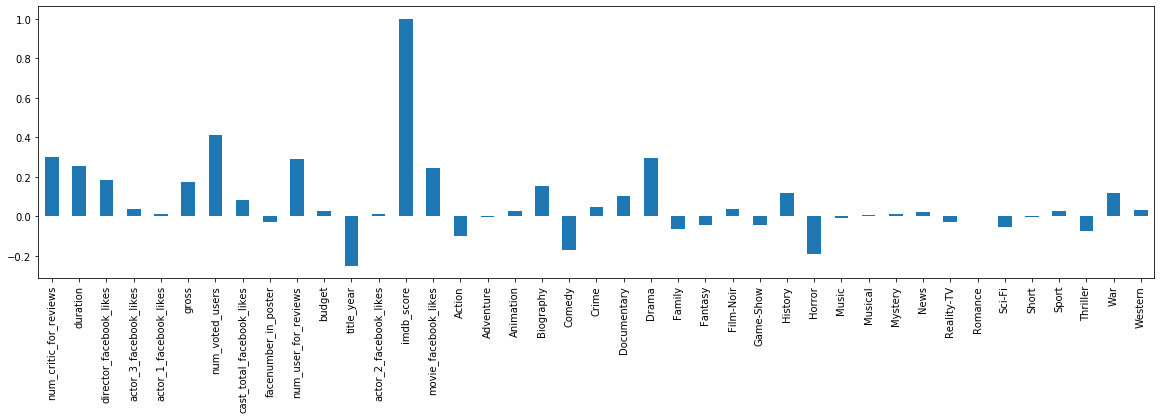

In [26]:
#Correlation with respect to the target variable
feature_correlation['imdb_score'].plot(kind='bar', figsize = (20,5))

In [27]:
#Reading the shape of the data
dataset_shape = movie_metadata.shape
dataset_shape

(5043, 53)

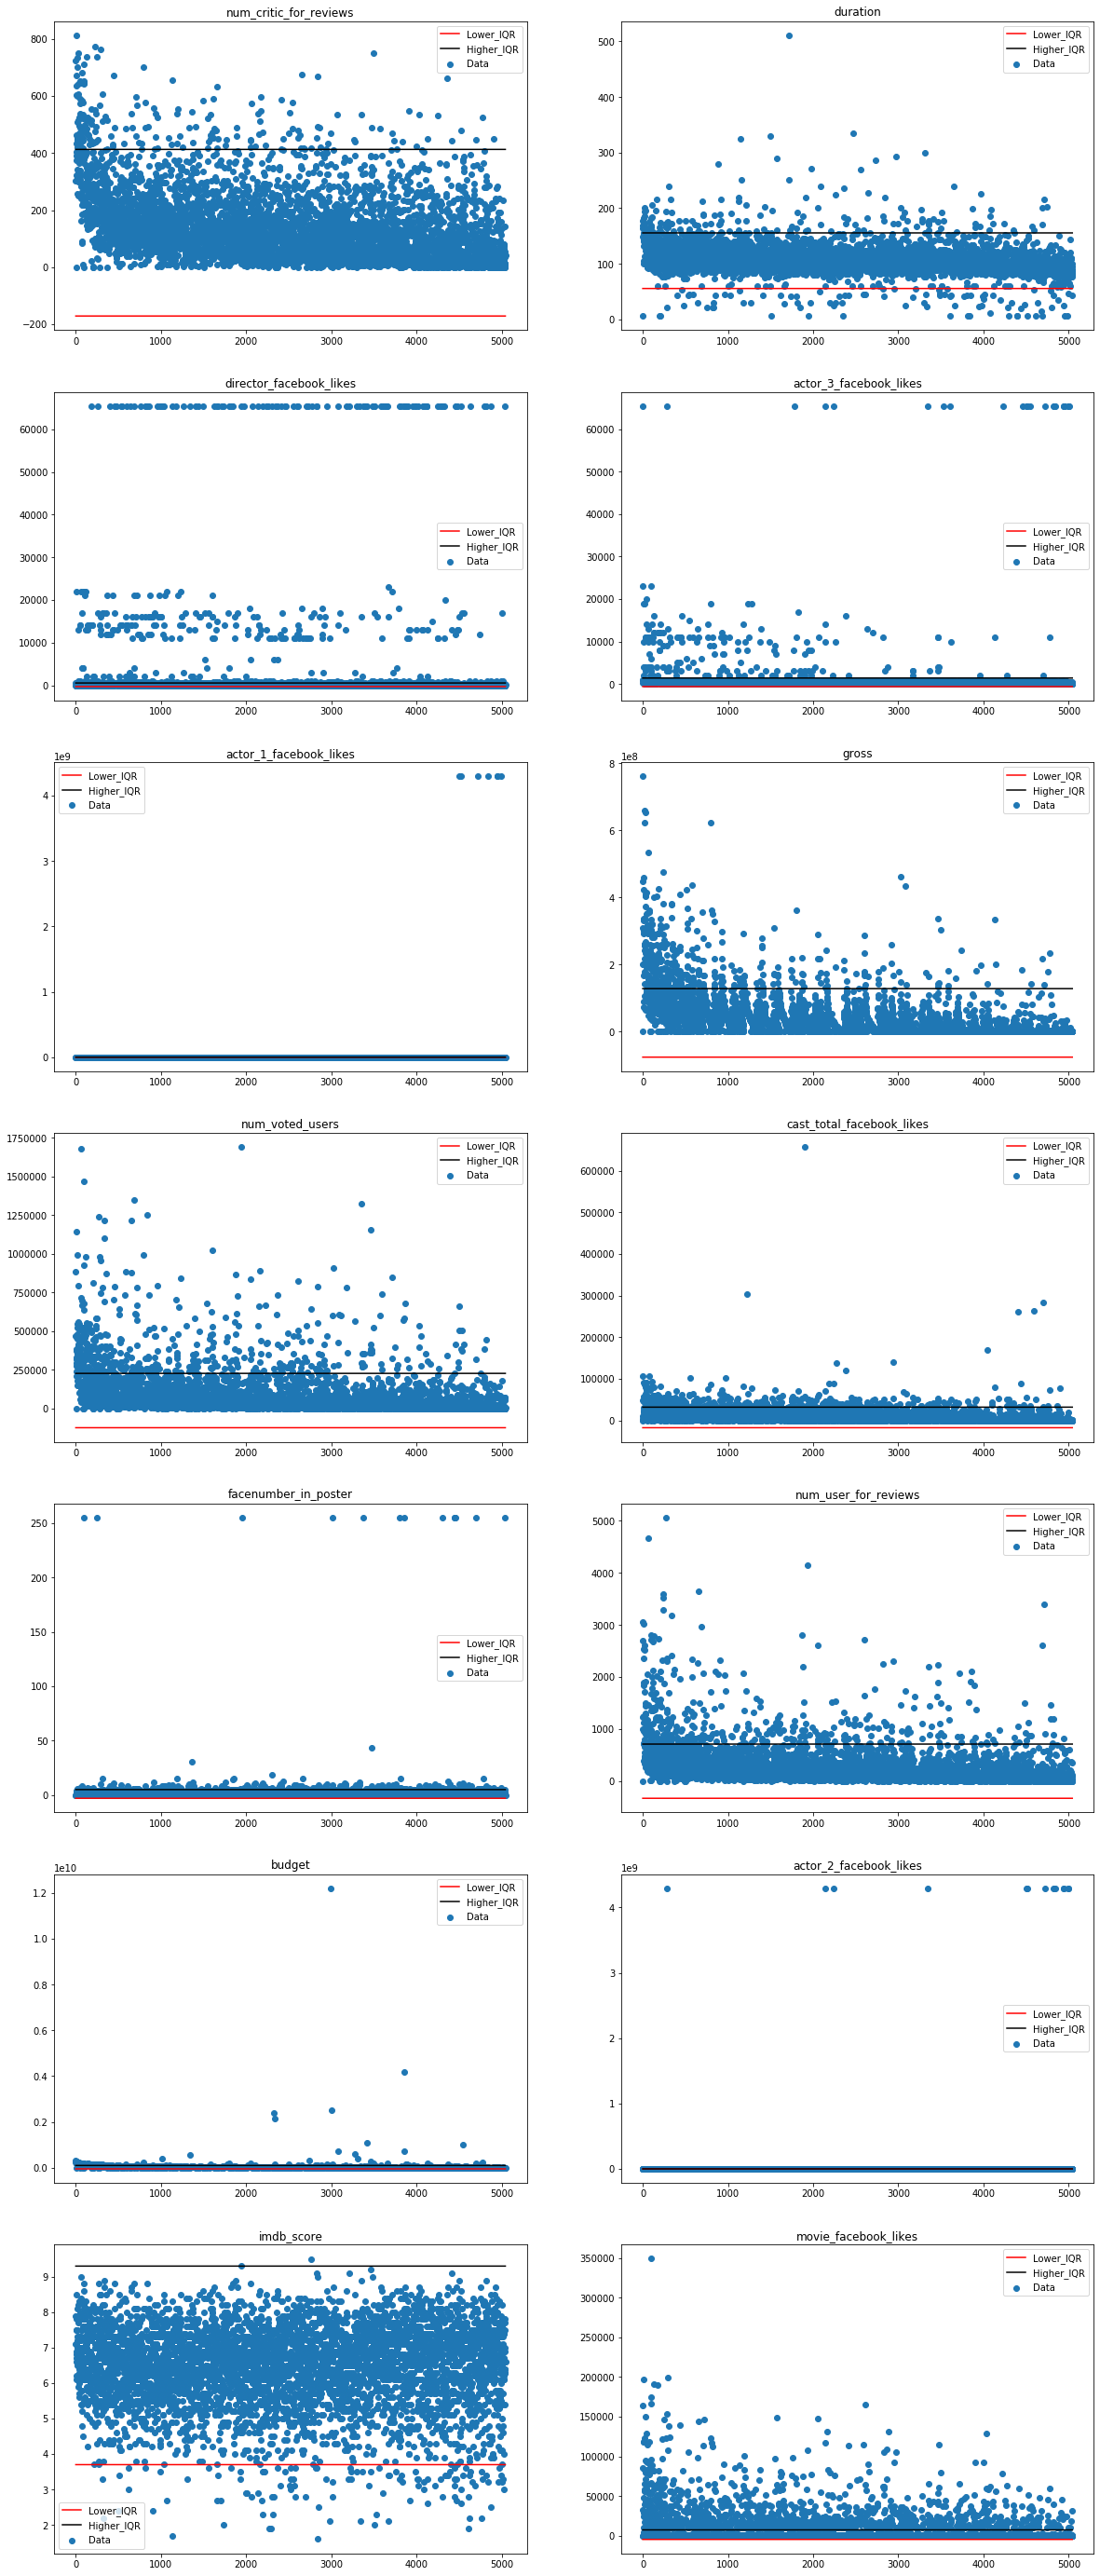

In [28]:
#Plotting the values of each feature
fig, ax = plt.subplots(len(numeric_features)//2, 2, figsize = (20,50))
for i in range(len(ax)):
    for j in range(len(ax[0])):
        #print(i, j, 2*i+j)
        ax[i][j].scatter(range(dataset_shape[0]), movie_metadata[numeric_features[2*i+j]])
        ax[i][j].plot(range(dataset_shape[0]), [movie_metadata_stats['lower_iqr_boundary'][numeric_features[2*i+j]] for _ in range(dataset_shape[0])], 
                      color = 'red')
        ax[i][j].plot(range(dataset_shape[0]), [movie_metadata_stats['higher_iqr_boundary'][numeric_features[2*i+j]] for _ in range(dataset_shape[0])], 
                      color = 'black')
        ax[i][j].legend(['Lower_IQR', 'Higher_IQR', 'Data'])
        ax[i][j].title.set_text(numeric_features[2*i+j])

In [29]:
#Checking the unique values in all categoricals Variables
movie_metadata[categorical_features].nunique()

color                2
director_name     2399
actor_2_name      3033
genres             914
actor_1_name      2098
movie_title       4917
actor_3_name      3522
language            48
country             66
content_rating      19
title_year          92
dtype: int64

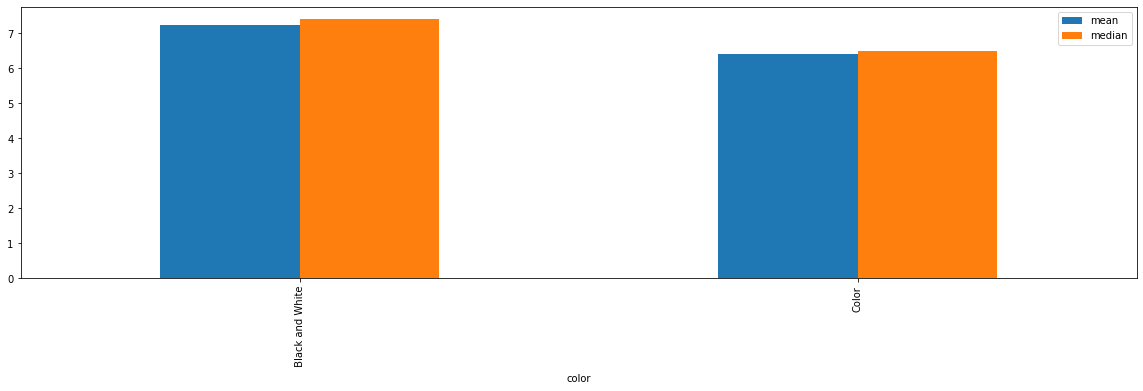

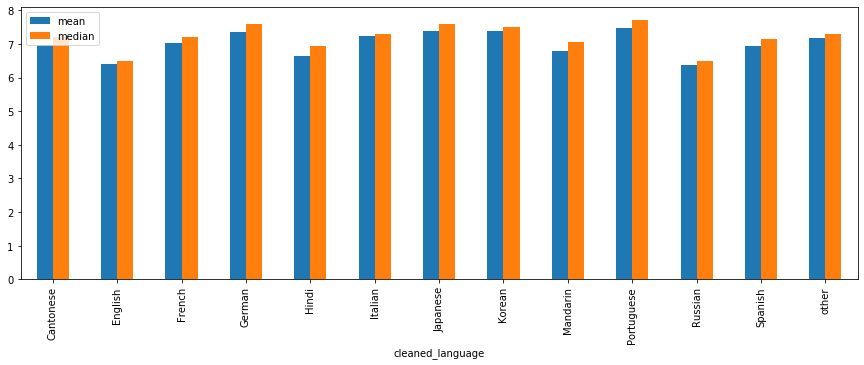

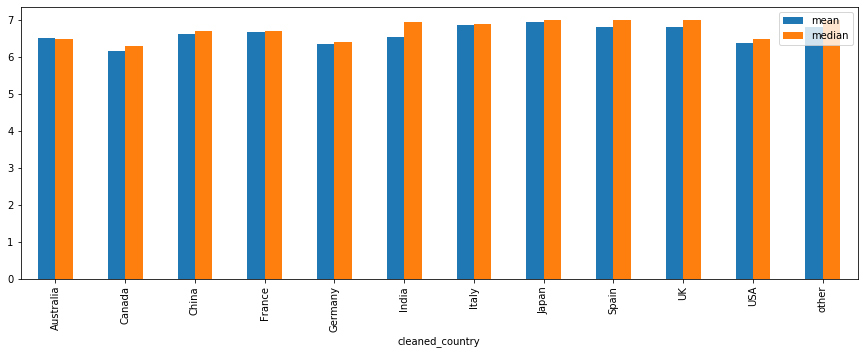

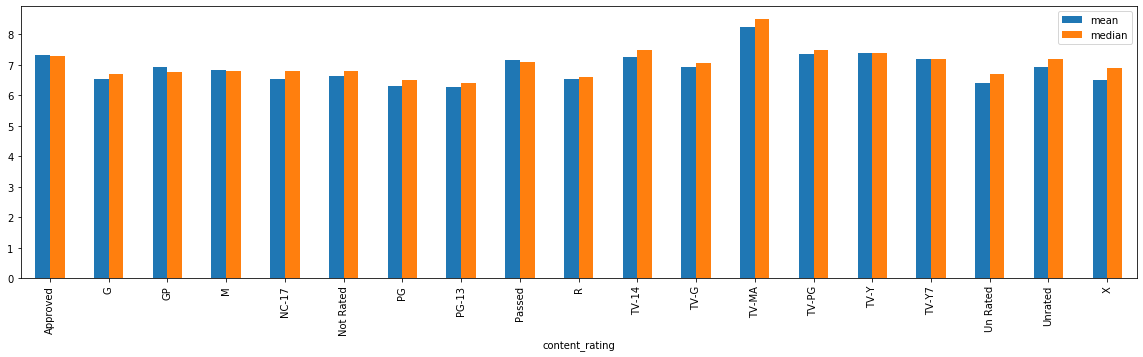

In [30]:
#Analysing the categorical Features with less uniwue values
movie_metadata.groupby('color')['imdb_score'].agg(['mean', 'median']).plot(kind = 'bar', figsize = (20,5))
movie_metadata.groupby('cleaned_language')['imdb_score'].agg(['mean', 'median']).plot(kind = 'bar', figsize = (15,5))
movie_metadata.groupby('cleaned_country')['imdb_score'].agg(['mean', 'median']).plot(kind = 'bar', figsize = (15,5))
movie_metadata.groupby('content_rating')['imdb_score'].agg(['mean', 'median']).plot(kind = 'bar', figsize = (20,5))

### Dropping the features which are not useful

In [31]:
movie_metadata.drop(['director_name', 'actor_2_name', 'genres', 'actor_1_name', 
                         'movie_title', 'actor_3_name', 'language', 'country'], axis=1, inplace = True)

In [32]:
categorical_features = movie_metadata.columns[movie_metadata.dtypes=='object']
numeric_features, categorical_features

(Index(['num_critic_for_reviews', 'duration', 'director_facebook_likes',
        'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross',
        'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster',
        'num_user_for_reviews', 'budget', 'actor_2_facebook_likes',
        'imdb_score', 'movie_facebook_likes'],
       dtype='object'),
 Index(['color', 'content_rating', 'cleaned_language', 'cleaned_country'], dtype='object'))

In [33]:
#Converting the categorical features into One hot encoded features
train_movie_data = pd.get_dummies(movie_metadata, columns = categorical_features)

In [34]:
#Updating the categorical_features variable
categorical_features = [feature for feature in train_movie_data.columns 
                        if feature not in numeric_features and feature!='imdb_score']

## Data Preprocessing 

### Scaling the Numerical features to (0,1) range

In [35]:
scaler = MinMaxScaler().fit(train_movie_data[train_numeric_features]) #Fitting the scaler with iput data
train_movie_data[train_numeric_features] = scaler.transform(train_movie_data[train_numeric_features]) # Transforming the iput data

### Splitting data into Train and Validation sets

In [36]:
train_x, test_x, train_y, test_y = train_test_split(train_movie_data.drop('imdb_score', axis = 1), 
                                                    train_movie_data['imdb_score'], shuffle = True, test_size = 0.2)

## Analysing with Light Gradient Boosting Model (LGBM)

In [37]:
params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'r2', 'rmse', 'mae'},
            'subsample': 0.9,
            'learning_rate': 0.01,
            'feature_fraction': 0.6,
            'bagging_fraction': 0.7,
            'num_leaves': 512,
            'max_depth': 10,
            }

lgb_train = lgb.Dataset(train_x, train_y, categorical_feature = categorical_features)
lgb_eval = lgb.Dataset(test_x, test_y, categorical_feature = categorical_features)
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=6000,
                valid_sets=(lgb_train, lgb_eval),
               early_stopping_rounds=200,
               verbose_eval = 200)
    

D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 0.595958	training's l1: 0.425257	valid_1's rmse: 0.762907	valid_1's l1: 0.541584
[400]	training's rmse: 0.472487	training's l1: 0.327346	valid_1's rmse: 0.726122	valid_1's l1: 0.502249
[600]	training's rmse: 0.414634	training's l1: 0.287085	valid_1's rmse: 0.720635	valid_1's l1: 0.493902
[800]	training's rmse: 0.380197	training's l1: 0.264526	valid_1's rmse: 0.720426	valid_1's l1: 0.492408
Early stopping, best iteration is:
[722]	training's rmse: 0.391462	training's l1: 0.271999	valid_1's rmse: 0.720042	valid_1's l1: 0.49243


In [38]:
print("Train Score : ", r2_score(gbm.predict(train_x), train_y), explained_variance_score(gbm.predict(train_x), train_y))
print("Test Score : ", r2_score(gbm.predict(test_x), test_y), explained_variance_score(gbm.predict(test_x), test_y))

Train Score :  0.8220004137368269 0.8220004137368269
Test Score :  0.21564167807324786 0.21565983870880467


### Plotting The feature importance as per LGBM Model

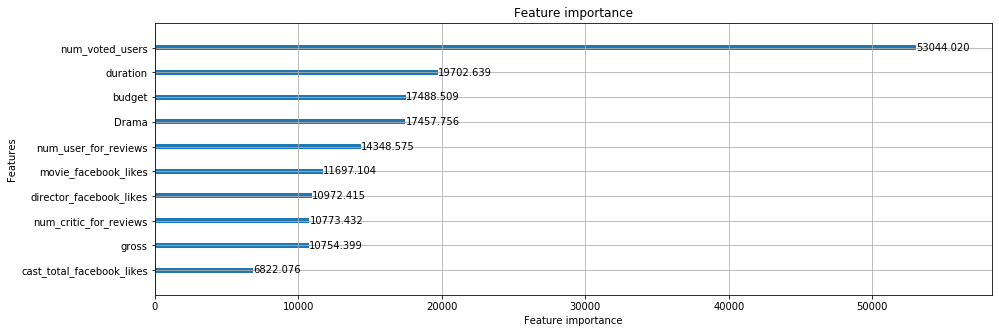

In [39]:
lgb.plot_importance(gbm, importance_type = 'gain', max_num_features = 10, figsize = (15,5))

### Sample Predicted data

In [40]:
print("Predicted : {}".format(gbm.predict(test_x[:10])), "Actual : \n{}".format(list(test_y[:10])), sep = '\n')

Predicted : [6.59669244 7.08713176 7.0894443  7.37667596 6.91264154 7.33843482
 7.10189543 5.38154421 6.4772032  6.74699943]
Actual : 
[6.599999904632568, 6.800000190734863, 6.199999809265137, 7.599999904632568, 6.599999904632568, 7.800000190734863, 6.800000190734863, 6.199999809265137, 7.199999809265137, 6.5]


### Plotting Predicted Data vs Actual data

Text(0, 0.5, 'imdb_score')

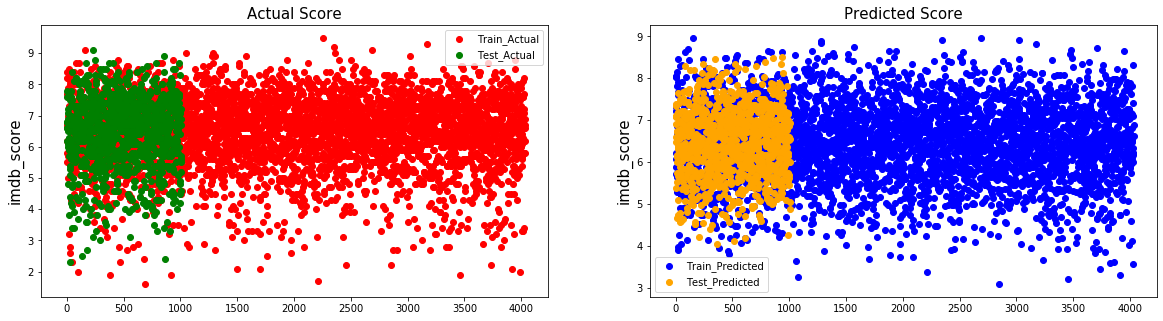

In [41]:
fig, ax = plt.subplots(1,2, figsize = (20,5))
ax[0].scatter(range(len(train_y)), train_y, c = 'r')
ax[0].scatter(range(len(test_y)), test_y, c = 'green')
ax[0].set_title("Actual Score", fontdict={'fontsize':15})
ax[0].set_ylabel("imdb_score", fontdict={'fontsize':15})
ax[0].legend(["Train_Actual", "Test_Actual"])
ax[1].scatter(range(len(train_y)), gbm.predict(train_x), c = 'b')
ax[1].scatter(range(len(test_y)), gbm.predict(test_x), c = 'orange')
ax[1].legend(["Train_Predicted", "Test_Predicted"])
ax[1].set_title("Predicted Score", fontdict={'fontsize':15})
ax[1].set_ylabel("imdb_score", fontdict={'fontsize':15})

## Analysing with Extra Trees Regression Model

In [42]:
et = ExtraTreesRegressor(bootstrap = True, max_depth = 16, max_leaf_nodes = 2048, random_state = 3, 
                         verbose = 1, oob_score = 'r2', criterion = 'mse')
et.fit(train_x, train_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.8s finished


ExtraTreesRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                    max_depth=16, max_features='auto', max_leaf_nodes=2048,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score='r2',
                    random_state=3, verbose=1, warm_start=False)

In [43]:
print("R2 Score : ", r2_score(et.predict(train_x), train_y), explained_variance_score(et.predict(train_x), train_y))
print("R2 Score : ", r2_score(et.predict(test_x), test_y), explained_variance_score(et.predict(test_x), test_y))
et.score(train_x, train_y), et.score(test_x, test_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


R2 Score :  0.8041687429309337 0.8042856374539064
R2 Score :  0.14210365506129363 0.1432317653198153


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


(0.8738931285242612, 0.5637418417795419)

### The important features as per Extra Trees Regression Model

In [44]:
print("Important Features : ", test_x.columns[et.feature_importances_>0.05])

Important Features :  Index(['num_critic_for_reviews', 'num_voted_users', 'title_year', 'Drama'], dtype='object')


### Sample Predicted data

In [45]:
print("Predicted : {}".format(et.predict(test_x)[:10]), "Actual : \n{}".format(list(test_y[:10])), sep = '\n')

Predicted : [6.41135732 6.745081   7.09474739 7.31743392 6.99427066 7.03515808
 6.56589028 5.60226222 6.21835716 6.19938814]
Actual : 
[6.599999904632568, 6.800000190734863, 6.199999809265137, 7.599999904632568, 6.599999904632568, 7.800000190734863, 6.800000190734863, 6.199999809265137, 7.199999809265137, 6.5]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


### Plotting Predicted Data vs Actual data

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Text(0, 0.5, 'imdb_score')

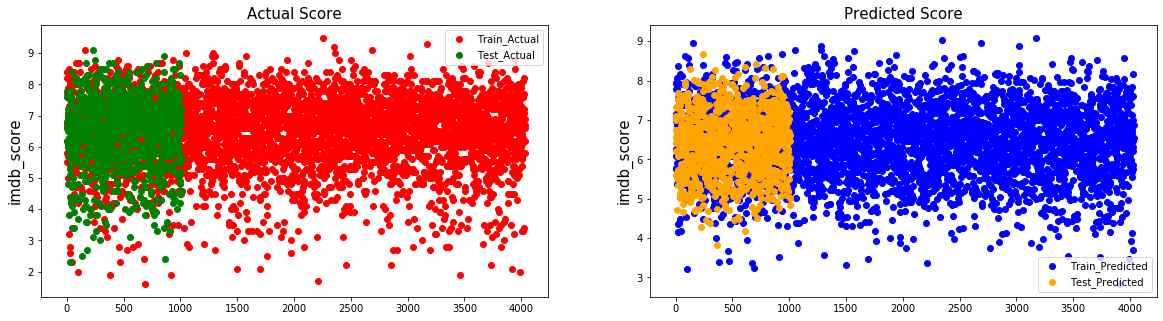

In [46]:
fig, ax = plt.subplots(1,2, figsize = (20,5))
ax[0].scatter(range(len(train_y)), train_y, c = 'r')
ax[0].scatter(range(len(test_y)), test_y, c = 'green')
ax[0].set_title("Actual Score", fontdict={'fontsize':15})
ax[0].set_ylabel("imdb_score", fontdict={'fontsize':15})
ax[0].legend(["Train_Actual", "Test_Actual"])
ax[1].scatter(range(len(train_y)), et.predict(train_x), c = 'b')
ax[1].scatter(range(len(test_y)), et.predict(test_x), c = 'orange')
ax[1].legend(["Train_Predicted", "Test_Predicted"])
ax[1].set_title("Predicted Score", fontdict={'fontsize':15})
ax[1].set_ylabel("imdb_score", fontdict={'fontsize':15})

## Analysing with Random Forest Regression Model

In [47]:
rf = RandomForestRegressor(max_depth = 16, max_features = None, max_leaf_nodes = 512, random_state = 3, 
                           verbose = 1, n_estimators = 100, oob_score = 'r2')
rf.fit(train_x, train_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.6s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=16, max_features=None, max_leaf_nodes=512,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score='r2',
                      random_state=3, verbose=1, warm_start=False)

In [48]:
print("R2 Score : ", r2_score(rf.predict(train_x), train_y), explained_variance_score(rf.predict(train_x), train_y))
print("R2 Score : ", r2_score(rf.predict(test_x), test_y), explained_variance_score(rf.predict(test_x), test_y))
rf.score(train_x, train_y), rf.score(test_x, test_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


R2 Score :  0.8574901921032242 0.8575345541012
R2 Score :  0.20272948672529334 0.20304509550962135


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


(0.9027903595817117, 0.5654806342501851)

### The important features as per Random Forest Regression Model

In [49]:
print("Important Features : ", test_x.columns[rf.feature_importances_>0.05])

Important Features :  Index(['num_voted_users', 'num_user_for_reviews', 'budget', 'title_year',
       'Drama'],
      dtype='object')


### Sample Predicted data

In [50]:
print("Predicted : {}".format(list(rf.predict(test_x))[:10]), "Actual : \n{}".format(list(test_y[:10])), sep = '\n')

Predicted : [6.625331529143421, 7.200989595803868, 7.199038520071464, 7.33478669518489, 6.8458801511429055, 7.064341926660037, 6.716499349618773, 5.805905770444659, 6.531440443129075, 6.322056745785243]
Actual : 
[6.599999904632568, 6.800000190734863, 6.199999809265137, 7.599999904632568, 6.599999904632568, 7.800000190734863, 6.800000190734863, 6.199999809265137, 7.199999809265137, 6.5]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


### Plotting Predicted data vs Acutal data

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Text(0, 0.5, 'imdb_score')

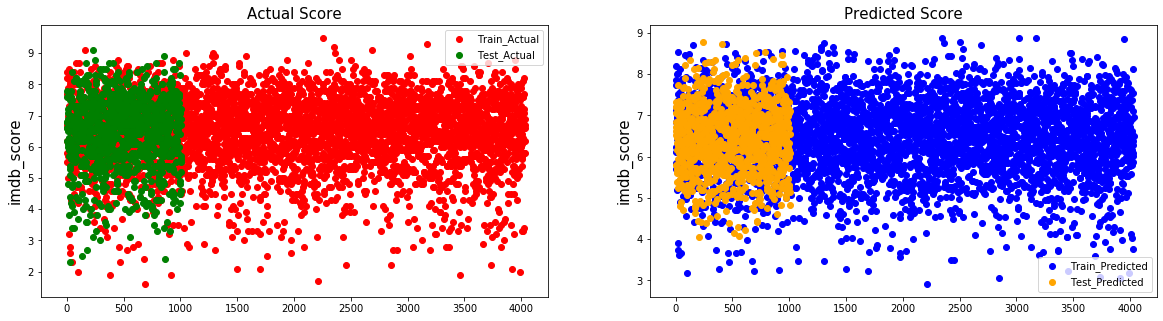

In [51]:
fig, ax = plt.subplots(1,2, figsize = (20,5))
ax[0].scatter(range(len(train_y)), train_y, c = 'r')
ax[0].scatter(range(len(test_y)), test_y, c = 'green')
ax[0].set_title("Actual Score", fontdict={'fontsize':15})
ax[0].set_ylabel("imdb_score", fontdict={'fontsize':15})
ax[0].legend(["Train_Actual", "Test_Actual"])
ax[1].scatter(range(len(train_y)), rf.predict(train_x), c = 'b')
ax[1].scatter(range(len(test_y)), rf.predict(test_x), c = 'orange')
ax[1].legend(["Train_Predicted", "Test_Predicted"])
ax[1].set_title("Predicted Score", fontdict={'fontsize':15})
ax[1].set_ylabel("imdb_score", fontdict={'fontsize':15})

## Analysing with Gradient Boosting Regression Model

In [52]:
gbr = GradientBoostingRegressor(learning_rate = 0.1, loss = 'huber', max_depth = 10, max_leaf_nodes = 512, 
                                random_state = 3, verbose = 1, n_estimators = 200, subsample = 0.8, 
                                n_iter_no_change = 5, validation_fraction = 0.2, tol = 1e-5)
gbr.fit(train_x, train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.5172           0.0651           39.69s
         2           0.4473           0.0589           39.59s
         3           0.4014           0.0406           39.88s
         4           0.3440           0.0371           39.88s
         5           0.3081           0.0284           40.20s
         6           0.2746           0.0250           40.03s
         7           0.2371           0.0231           39.60s
         8           0.2158           0.0174           39.23s
         9           0.1883           0.0180           39.30s
        10           0.1751           0.0100           38.86s
        20           0.0727           0.0031           36.21s
        30           0.0371           0.0007           32.98s
        40           0.0205           0.0002           29.81s
        50           0.0132           0.0001           26.97s
        60           0.0084           0.0001           24.37s
       

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='huber',
                          max_depth=10, max_features=None, max_leaf_nodes=512,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=5, presort='deprecated',
                          random_state=3, subsample=0.8, tol=1e-05,
                          validation_fraction=0.2, verbose=1, warm_start=False)

In [53]:
print("R2 Score : ", r2_score(gbr.predict(train_x), train_y), explained_variance_score(gbr.predict(train_x), train_y))
print("R2 Score : ", r2_score(gbr.predict(test_x), test_y), explained_variance_score(gbr.predict(test_x), test_y))
gbr.score(train_x, train_y), gbr.score(test_x, test_y)

R2 Score :  0.907356607282926 0.9073590700218614
R2 Score :  0.221290333470881 0.22132880155193724


(0.9166620922662536, 0.5585305499949862)

### The important features as per Gradient Boosting Regression Model

In [54]:
print("Important Features : ", test_x.columns[gbr.feature_importances_>0.05])

Important Features :  Index(['num_voted_users', 'budget', 'title_year', 'Drama'], dtype='object')


### Sample Predicted data

In [55]:
print("Predicted : {}".format(gbr.predict(test_x)[:10]), "Actual : \n{}".format(list(test_y[:10])), sep = '\n')

Predicted : [6.34217906 7.0383031  7.34447086 7.51586936 6.66875285 7.42873512
 6.77738455 5.53390615 6.51349595 6.43968986]
Actual : 
[6.599999904632568, 6.800000190734863, 6.199999809265137, 7.599999904632568, 6.599999904632568, 7.800000190734863, 6.800000190734863, 6.199999809265137, 7.199999809265137, 6.5]


### Plotting Predicted data vs Acutal data

Text(0, 0.5, 'imdb_score')

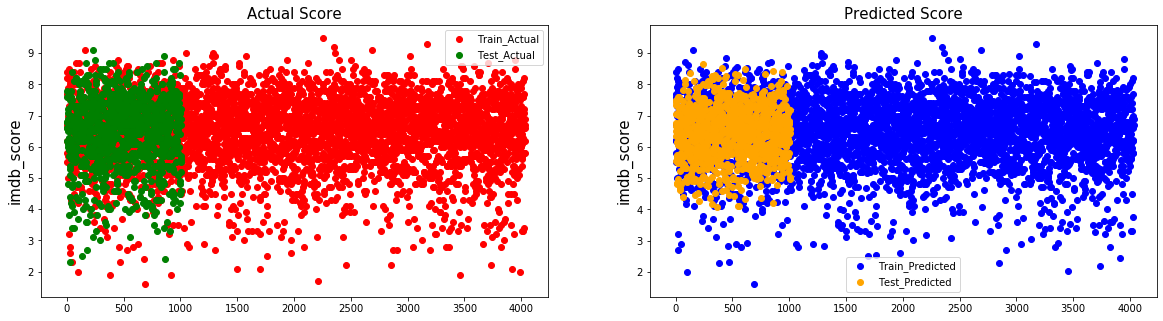

In [56]:
fig, ax = plt.subplots(1,2, figsize = (20,5))
ax[0].scatter(range(len(train_y)), train_y, c = 'r')
ax[0].scatter(range(len(test_y)), test_y, c = 'green')
ax[0].set_title("Actual Score", fontdict={'fontsize':15})
ax[0].set_ylabel("imdb_score", fontdict={'fontsize':15})
ax[0].legend(["Train_Actual", "Test_Actual"])
ax[1].scatter(range(len(train_y)), gbr.predict(train_x), c = 'b')
ax[1].scatter(range(len(test_y)), gbr.predict(test_x), c = 'orange')
ax[1].legend(["Train_Predicted", "Test_Predicted"])
ax[1].set_title("Predicted Score", fontdict={'fontsize':15})
ax[1].set_ylabel("imdb_score", fontdict={'fontsize':15})

## Analysing with Histogram based Gradient Boosting Regression Model

In [57]:
hgbr = HistGradientBoostingRegressor(max_depth = 10, max_leaf_nodes = 512, scoring = ['r2', 'explained_variance_score'], 
                                     l2_regularization = 0.1, random_state = 3, verbose = 2, validation_fraction = 0.3, 
                                    max_iter = 50)
hgbr.fit(train_x, train_y)

Binning 0.003 GB of training data: 0.022 s
Fitting gradient boosted rounds:
[1/50] 1 tree, 129 leaves, max depth = 10, in 0.135s
[2/50] 1 tree, 117 leaves, max depth = 10, in 0.112s
[3/50] 1 tree, 121 leaves, max depth = 10, in 0.140s
[4/50] 1 tree, 110 leaves, max depth = 10, in 0.110s
[5/50] 1 tree, 135 leaves, max depth = 10, in 0.137s
[6/50] 1 tree, 110 leaves, max depth = 10, in 0.158s
[7/50] 1 tree, 122 leaves, max depth = 10, in 0.126s
[8/50] 1 tree, 106 leaves, max depth = 10, in 0.109s
[9/50] 1 tree, 115 leaves, max depth = 10, in 0.122s
[10/50] 1 tree, 109 leaves, max depth = 10, in 0.115s
[11/50] 1 tree, 115 leaves, max depth = 10, in 0.119s
[12/50] 1 tree, 128 leaves, max depth = 10, in 0.138s
[13/50] 1 tree, 125 leaves, max depth = 10, in 0.207s
[14/50] 1 tree, 120 leaves, max depth = 10, in 0.119s
[15/50] 1 tree, 125 leaves, max depth = 10, in 0.126s
[16/50] 1 tree, 117 leaves, max depth = 10, in 0.124s
[17/50] 1 tree, 125 leaves, max depth = 10, in 0.126s
[18/50] 1 tree,

HistGradientBoostingRegressor(l2_regularization=0.1, learning_rate=0.1,
                              loss='least_squares', max_bins=255, max_depth=10,
                              max_iter=50, max_leaf_nodes=512,
                              min_samples_leaf=20, n_iter_no_change=None,
                              random_state=3,
                              scoring=['r2', 'explained_variance_score'],
                              tol=1e-07, validation_fraction=0.3, verbose=2,
                              warm_start=False)

In [58]:
print("R2 Score : ", r2_score(hgbr.predict(train_x), train_y), explained_variance_score(hgbr.predict(train_x), train_y))
print("R2 Score : ", r2_score(hgbr.predict(test_x), test_y), explained_variance_score(hgbr.predict(test_x), test_y))
hgbr.score(train_x, train_y), hgbr.score(test_x, test_y)

R2 Score :  0.8222340395007698 0.8222340395458141
R2 Score :  0.3189928438303389 0.31960974950281695


(0.8766997255022478, 0.5965149590042824)

### The important features as per Histogram based Gradient Boosting Regression Model

In [59]:
print("Predicted : {}".format(hgbr.predict(test_x)[:10]), "Actual : \n{}".format(list(test_y[:10])), sep = '\n')

Predicted : [6.30059921 7.15431899 7.16288484 7.56457651 6.81367162 7.42817334
 6.60771489 5.80966181 6.4472299  6.3198474 ]
Actual : 
[6.599999904632568, 6.800000190734863, 6.199999809265137, 7.599999904632568, 6.599999904632568, 7.800000190734863, 6.800000190734863, 6.199999809265137, 7.199999809265137, 6.5]


### Plotting Predicted data vs Acutal data

Text(0, 0.5, 'imdb_score')

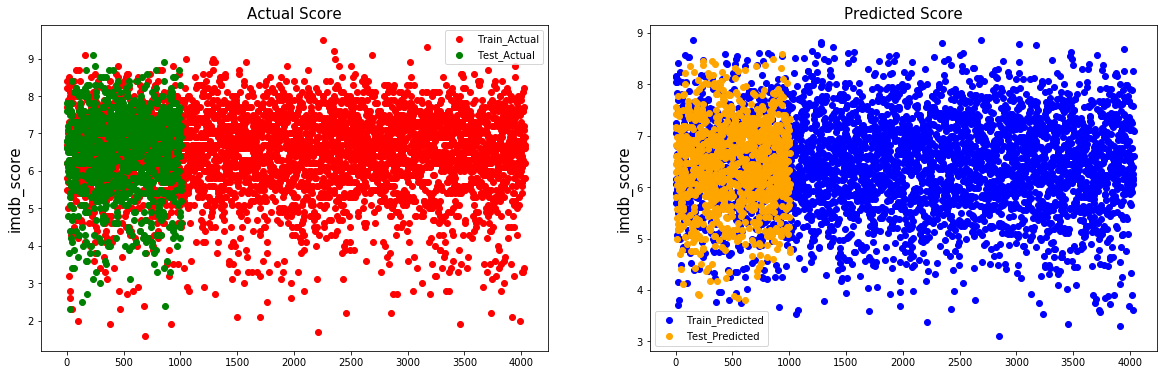

In [60]:
fig, ax = plt.subplots(1, 2, figsize = (20,6))
ax[0].scatter(range(len(train_y)), train_y, c = 'r')
ax[0].scatter(range(len(test_y)), test_y, c = 'green')
ax[0].set_title("Actual Score", fontdict={'fontsize':15})
ax[0].set_ylabel("imdb_score", fontdict={'fontsize':15})
ax[0].legend(["Train_Actual", "Test_Actual"])
ax[1].scatter(range(len(train_y)), hgbr.predict(train_x), c = 'b')
ax[1].scatter(range(len(test_y)), hgbr.predict(test_x), c = 'orange')
ax[1].legend(["Train_Predicted", "Test_Predicted"])
ax[1].set_title("Predicted Score", fontdict={'fontsize':15})
ax[1].set_ylabel("imdb_score", fontdict={'fontsize':15})